Import dataset

In [71]:
import numpy as np
import pandas as pd

# first download 5-year stock data from yahoo.finance
# then change data type in 'Date' column into yy-mm-dd type and save
df = pd.read_csv('NVDA.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-19,62.044998,62.337502,59.250000,60.250000,59.649902,71377200
1,2018-03-20,60.279999,62.787498,60.279999,62.395000,61.773552,55469600
2,2018-03-21,62.330002,63.000000,61.832500,62.139999,61.521091,43868800
3,2018-03-22,61.500000,61.970001,60.084999,60.462502,59.860310,55119600
4,2018-03-23,60.599998,60.625000,58.130001,58.242500,57.662403,73562000
...,...,...,...,...,...,...,...
1504,2024-03-11,864.289978,887.969971,841.659973,857.739990,857.739990,67836400
1505,2024-03-12,880.489990,919.599976,861.500000,919.130005,919.130005,66807500
1506,2024-03-13,910.549988,915.039978,884.349976,908.880005,908.880005,63571300
1507,2024-03-14,895.770020,906.460022,866.000000,879.440002,879.440002,60231800


XGBoost

In [72]:
test_size = 0.05               # proportion of dataset to be used as test set
cv_size = 0.25                 # proportion of dataset to be used as cross-validation set
N = 7                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

Instead of using the same mean and variance to do scaling for train, dev and test sets, we scale the train set to have mean 0 and var 1, and then whenever we do prediction on dev or test set we scale the previous N values to also have mean 0 and var 1 (ie. use the means and variances of the previous N values to do scaling. We do this for both feature columns and target columns). By doing so, we can have the smallest RMSE and MAPE.

In [73]:
import math
import matplotlib
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
# from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    
    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [74]:
# extract month and form a new column
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df.head(20)

,Date,Open,High,Low,Close,Adj Close,Volume,Month
0,2018-03-19,62.044998,62.337502,59.250000,60.250000,59.649902,71377200,3
1,2018-03-20,60.279999,62.787498,60.279999,62.395000,61.773552,55469600,3
2,2018-03-21,62.330002,63.000000,61.832500,62.139999,61.521091,43868800,3
3,2018-03-22,61.500000,61.970001,60.084999,60.462502,59.860310,55119600,3
4,2018-03-23,60.599998,60.625000,58.130001,58.242500,57.662403,73562000,3
5,2018-03-26,59.500000,61.132500,58.974998,61.119999,60.511250,61142400,3
6,2018-03-27,61.937500,62.500000,54.962502,56.380001,55.818466,140900000,3
7,2018-03-28,56.032501,57.347500,54.250000,55.337502,54.786343,94590400,3
8,2018-03-29,56.027500,58.875000,55.174999,57.897499,57.320843,91662800,3
9,2018-04-02,57.185001,58.662498,54.375000,55.262501,54.712086,92209200,4


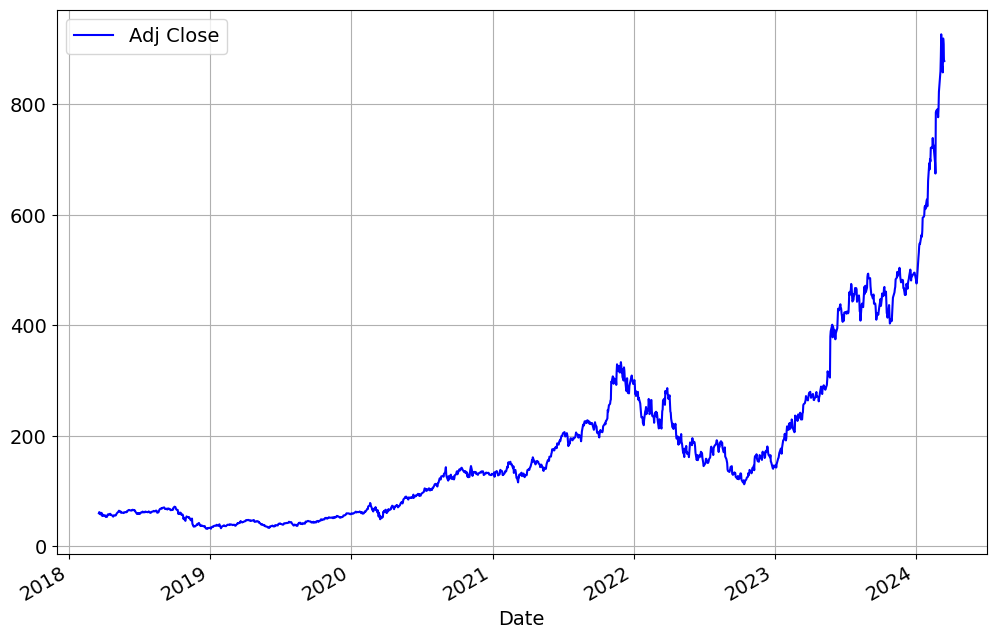

In [75]:
# rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = df.plot(x='Date', y='Adj Close', style='b-', grid=True)

# Feature Engineering

Generate the following features:
* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [76]:
# Get difference between high and low of each day
df['range_hl'] = df['High'] - df['Low']
df.drop(['High', 'Low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['Open'] - df['Close']
df.drop(['Open', 'Close'], axis=1, inplace=True)

df.head()

,Date,Adj Close,Volume,Month,range_hl,range_oc
0,2018-03-19,59.649902,71377200,3,3.087502,1.794998
1,2018-03-20,61.773552,55469600,3,2.507499,-2.115001
2,2018-03-21,61.521091,43868800,3,1.167500,0.190003
3,2018-03-22,59.860310,55119600,3,1.885002,1.037498
4,2018-03-23,57.662403,73562000,3,2.494999,2.357498


Now use lags up to N number of days to use as features.

In [77]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['Adj Close', 'range_hl', 'range_oc', 'Volume']
lag_cols

['Adj Close', 'range_hl', 'range_oc', 'Volume']

In [78]:
shift_range = [x+1 for x in range(N)]

for shift in shift_range:
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df

,Date,Adj Close,Volume,Month,range_hl,range_oc,order_day,Adj Close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_5,Volume_lag_5,Adj Close_lag_6,range_hl_lag_6,range_oc_lag_6,Volume_lag_6,Adj Close_lag_7,range_hl_lag_7,range_oc_lag_7,Volume_lag_7
7,2018-03-28,54.786343,94590400,3,3.097500,0.694999,7,55.818466,7.537498,5.557499,...,0.190003,43868800.0,61.773552,2.507499,-2.115001,55469600.0,59.649902,3.087502,1.794998,71377200.0
8,2018-03-29,57.320843,91662800,3,3.700001,-1.869999,8,54.786343,3.097500,0.694999,...,1.037498,55119600.0,61.521091,1.167500,0.190003,43868800.0,61.773552,2.507499,-2.115001,55469600.0
9,2018-04-02,54.712086,92209200,4,4.287498,1.922500,9,57.320843,3.700001,-1.869999,...,2.357498,73562000.0,59.860310,1.885002,1.037498,55119600.0,61.521091,1.167500,0.190003,43868800.0
10,2018-04-03,55.776386,66743200,4,2.250000,0.612499,10,54.712086,4.287498,1.922500,...,-1.619999,61142400.0,57.662403,2.494999,2.357498,73562000.0,59.860310,1.885002,1.037498,55119600.0
11,2018-04-04,55.996666,78916800,4,3.165001,-2.807502,11,55.776386,2.250000,0.612499,...,5.557499,140900000.0,60.511250,2.157502,-1.619999,61142400.0,57.662403,2.494999,2.357498,73562000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504,2024-03-11,857.739990,67836400,3,46.309998,6.549988,1504,875.280029,108.940002,76.099976,...,-11.070007,61561600.0,822.751404,28.650024,-22.789978,47677700.0,791.082886,16.400024,-0.179993,50728900.0
1505,2024-03-12,919.130005,66807500,3,58.099976,-38.640015,1505,857.739990,46.309998,6.549988,...,-6.940003,52063900.0,852.330017,39.760010,-11.070007,61561600.0,822.751404,28.650024,-22.789978,47677700.0
1506,2024-03-13,908.880005,63571300,3,30.690002,1.669983,1506,919.130005,58.099976,-38.640015,...,-6.780029,58252000.0,859.640015,26.799988,-6.940003,52063900.0,852.330017,39.760010,-11.070007,61561600.0
1507,2024-03-14,879.440002,60231800,3,40.460022,16.330018,1507,908.880005,30.690002,1.669983,...,-25.109985,60811900.0,887.000000,26.940002,-6.780029,58252000.0,859.640015,26.799988,-6.940003,52063900.0


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 7 to 1508
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             1502 non-null   datetime64[ns]
 1   Adj Close        1502 non-null   float64       
 2   Volume           1502 non-null   int64         
 3   Month            1502 non-null   int32         
 4   range_hl         1502 non-null   float64       
 5   range_oc         1502 non-null   float64       
 6   order_day        1502 non-null   int64         
 7   Adj Close_lag_1  1502 non-null   float64       
 8   range_hl_lag_1   1502 non-null   float64       
 9   range_oc_lag_1   1502 non-null   float64       
 10  Volume_lag_1     1502 non-null   float64       
 11  Adj Close_lag_2  1502 non-null   float64       
 12  range_hl_lag_2   1502 non-null   float64       
 13  range_oc_lag_2   1502 non-null   float64       
 14  Volume_lag_2     1502 non-null   float64

# Get mean and std dev at timestamp t using values from t-1, ..., t-N

In [80]:
cols_list = [
"Adj Close",
"range_hl",
"range_oc",
"Volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df

,Date,Adj Close,Volume,Month,range_hl,range_oc,order_day,Adj Close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_7,Volume_lag_7,Adj Close_mean,Adj Close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,Volume_mean,Volume_std
7,2018-03-28,54.786343,94590400,3,3.097500,0.694999,7,55.818466,7.537498,5.557499,...,1.794998,71377200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-03-29,57.320843,91662800,3,3.700001,-1.869999,8,54.786343,3.097500,0.694999,...,-2.115001,55469600.0,54.786343,NaN,3.097500,NaN,0.694999,NaN,9.459040e+07,NaN
9,2018-04-02,54.712086,92209200,4,4.287498,1.922500,9,57.320843,3.700001,-1.869999,...,0.190003,43868800.0,56.053593,1.792162,3.398750,0.426033,-0.587500,1.813727,9.312660e+07,2.070126e+06
10,2018-04-03,55.776386,66743200,4,2.250000,0.612499,10,54.712086,4.287498,1.922500,...,1.037498,55119600.0,55.606424,1.485195,3.695000,0.595015,0.249167,1.935158,9.282080e+07,1.556680e+06
11,2018-04-04,55.996666,78916800,4,3.165001,-2.807502,11,55.776386,2.250000,0.612499,...,2.357498,73562000.0,55.648915,1.215630,3.333750,0.870652,0.340000,1.590459,8.630140e+07,1.310060e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504,2024-03-11,857.739990,67836400,3,46.309998,6.549988,1504,875.280029,108.940002,76.099976,...,-0.179993,50728900.0,859.253479,43.973703,39.877145,31.232952,0.461426,34.535779,6.348509e+07,2.259334e+07
1505,2024-03-12,919.130005,66807500,3,58.099976,-38.640015,1505,857.739990,46.309998,6.549988,...,-22.789978,47677700.0,868.775922,32.461366,44.149998,29.482732,1.422852,34.608547,6.592901e+07,2.189809e+07
1506,2024-03-13,908.880005,63571300,3,30.690002,1.669983,1506,919.130005,58.099976,-38.640015,...,-11.070007,61561600.0,882.544294,30.035375,48.357134,28.999545,-0.841439,36.899395,6.866184e+07,2.038194e+07
1507,2024-03-14,879.440002,60231800,3,40.460022,16.330018,1507,908.880005,30.690002,1.669983,...,-6.940003,52063900.0,890.622864,28.096758,47.061419,29.643174,0.978559,36.623965,6.894894e+07,2.027915e+07


# Split into train, dev and test set

In [81]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("total number = ", len(df))
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

total number =  1502
num_train = 1052
num_cv = 375
num_test = 75
train.shape = (1052, 43)
cv.shape = (375, 43)
train_cv.shape = (1427, 43)
test.shape = (75, 43)


# Scale the train, dev and test set

In [82]:
cols_to_scale = ["Adj Close"]

for i in range(1,N+1):
    cols_to_scale.append("Adj Close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("Volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['Date', 'Month']] = train.reset_index()[['Date', 'Month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled

scaler.mean_ = [1.13737958e+02 1.13613749e+02 4.49205317e+00 5.75378517e-02
 4.60915606e+07 1.13492682e+02 4.48668008e+00 6.19389933e-02
 4.60794927e+07 1.13378020e+02 4.46937495e+00 8.14328070e-02
 4.60546871e+07 1.13273765e+02 4.46060594e+00 9.14969715e-02
 4.60328300e+07 1.13178882e+02 4.45394957e+00 8.82935399e-02
 4.60185846e+07 1.13077177e+02 4.44933692e+00 9.22146331e-02
 4.60104864e+07 1.12975389e+02 4.43653987e+00 8.78562614e-02
 4.60080783e+07]
scaler.var_ = [5.88970905e+03 5.88785181e+03 2.25871730e+01 1.66874236e+01
 5.21194110e+14 5.88527563e+03 2.25818603e+01 1.66522608e+01
 5.20677489e+14 5.88423476e+03 2.23354535e+01 1.63416099e+01
 5.18666119e+14 5.88394851e+03 2.22998073e+01 1.62541983e+01
 5.17766805e+14 5.88428953e+03 2.22969920e+01 1.62427613e+01
 5.17614772e+14 5.88385366e+03 2.22925445e+01 1.62092928e+01
 5.17392643e+14 5.88382027e+03 2.21549553e+01 1.61744479e+01
 5.17264367e+14]
train_scaled.shape = (1052, 29)
train_scaled.shape = (1052, 31)


,Adj Close,Adj Close_lag_1,range_hl_lag_1,range_oc_lag_1,Volume_lag_1,Adj Close_lag_2,range_hl_lag_2,range_oc_lag_2,Volume_lag_2,Adj Close_lag_3,...,Adj Close_lag_6,range_hl_lag_6,range_oc_lag_6,Volume_lag_6,Adj Close_lag_7,range_hl_lag_7,range_oc_lag_7,Volume_lag_7,Date,Month
0,-0.768155,-0.753206,0.640796,1.346372,4.152860,-0.690622,-0.490143,-0.412167,0.660122,-0.726327,...,-0.668832,-0.411276,-0.548230,0.415853,-0.695193,-0.286608,0.424478,1.115448,2018-03-28,3
1,-0.735130,-0.766657,-0.293430,0.156048,2.124377,-0.751793,0.642002,1.346714,4.155448,-0.689188,...,-0.672123,-0.695084,0.024289,-0.094156,-0.667507,-0.409832,-0.547736,0.416011,2018-03-29,3
2,-0.769122,-0.733627,-0.166657,-0.471854,1.996140,-0.765247,-0.292334,0.155134,2.125960,-0.750365,...,-0.693775,-0.543119,0.234790,0.400466,-0.670798,-0.694520,0.025399,-0.094061,2018-04-02,4
3,-0.755254,-0.767625,-0.043041,0.456536,2.020074,-0.732209,-0.165546,-0.473431,1.997659,-0.763820,...,-0.722428,-0.413923,0.562653,1.211254,-0.692450,-0.542084,0.236127,0.400622,2018-04-03,4
4,-0.752384,-0.753755,-0.471753,0.135853,0.904596,-0.766215,-0.041915,0.455940,2.021605,-0.730779,...,-0.685288,-0.485404,-0.425281,0.665248,-0.721103,-0.412488,0.564342,1.211510,2018-04-04,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047,0.620233,0.718789,0.603449,-1.541614,0.783951,0.693966,2.538558,1.548273,1.219676,0.751508,...,0.773683,0.502101,0.585628,0.269676,0.832562,1.893700,-2.304434,0.924909,2022-05-24,5
1048,0.727078,0.621950,0.773881,0.857394,0.559072,0.720524,0.604650,-1.544319,0.784868,0.695522,...,0.892559,0.618591,-0.278736,0.552729,0.775012,0.506377,0.587342,0.269815,2022-05-25,5
1049,0.841080,0.728811,1.392491,-2.351893,1.402632,0.623664,0.775103,0.857220,0.559878,0.722083,...,0.731236,1.713578,1.882176,0.373934,0.893889,0.623227,-0.277953,0.552903,2022-05-26,5
1050,0.966013,0.842831,3.410335,-4.457142,2.346329,0.730549,1.393785,-2.355454,1.403857,0.625214,...,0.755455,1.076070,-0.487379,0.708710,0.732565,1.721610,1.885286,0.374087,2022-05-27,5


In [83]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['Date', 'Month']] = train_cv.reset_index()[['Date', 'Month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled

scaler_train_cv.mean_ = [ 1.56219513e+02  1.55920609e+02  5.93425380e+00 -7.93554450e-02
  4.71771866e+07  1.55628258e+02  5.92752467e+00 -8.53540441e-02
  4.71993856e+07  1.55327325e+02  5.91073769e+00 -9.16627246e-02
  4.71879069e+07  1.55019327e+02  5.90298366e+00 -9.22110848e-02
  4.71868872e+07  1.54709235e+02  5.89422226e+00 -8.43904793e-02
  4.71886089e+07  1.54407105e+02  5.89100396e+00 -8.74563378e-02
  4.72046910e+07  1.54102211e+02  5.88479338e+00 -8.05852957e-02
  4.72309009e+07]
scaler_train_cv.var_ = [1.37270736e+04 1.36595113e+04 3.00703424e+01 2.49188617e+01
 4.50273698e+14 1.35932477e+04 3.00565093e+01 2.48859611e+01
 4.50190016e+14 1.35228891e+04 2.97693387e+01 2.47983052e+01
 4.49396651e+14 1.34462327e+04 2.97459115e+01 2.47966374e+01
 4.49378990e+14 1.33669068e+04 2.97192742e+01 2.47137124e+01
 4.49363332e+14 1.32927124e+04 2.97262827e+01 2.47127411e+01
 4.49260356e+14 1.32177470e+04 2.97060255e+01 2.46711923e+01
 4.49546495e+14]
train_cv_scaled.shape = (1427, 29)
t

,Adj Close,Adj Close_lag_1,range_hl_lag_1,range_oc_lag_1,Volume_lag_1,Adj Close_lag_2,range_hl_lag_2,range_oc_lag_2,Volume_lag_2,Adj Close_lag_3,...,Adj Close_lag_6,range_hl_lag_6,range_oc_lag_6,Volume_lag_6,Adj Close_lag_7,range_hl_lag_7,range_oc_lag_7,Volume_lag_7,Date,Month
0,-0.865747,-0.856497,0.292368,1.129205,4.416793,-0.815824,-0.687661,-0.307631,0.657141,-0.839854,...,-0.803455,-0.620578,-0.407859,0.389932,-0.821550,-0.513234,0.377608,1.138841,2018-03-28,3
1,-0.844115,-0.865328,-0.517312,0.155123,2.234401,-0.856074,0.293663,1.131153,4.416157,-0.815356,...,-0.805645,-0.866351,0.055813,-0.157385,-0.803078,-0.619650,-0.409586,0.388572,2018-03-29,3
2,-0.866381,-0.843642,-0.407439,-0.358711,2.096434,-0.864927,-0.516204,0.156428,2.233562,-0.855711,...,-0.820049,-0.734752,0.226295,0.373419,-0.805274,-0.865507,0.054477,-0.158571,2018-04-02,4
3,-0.857297,-0.865963,-0.300303,0.401022,2.122184,-0.843188,-0.406306,-0.357746,2.095583,-0.864586,...,-0.839113,-0.622871,0.491825,1.243518,-0.819720,-0.733863,0.225102,0.372064,2018-04-03,4
4,-0.855417,-0.856857,-0.671862,0.138596,0.922070,-0.865564,-0.299145,0.402490,2.121335,-0.842791,...,-0.814403,-0.684772,-0.308285,0.657571,-0.838837,-0.621944,0.490855,1.241886,2018-04-04,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422,2.968546,2.883389,0.212587,0.468628,-0.690713,2.908524,1.098517,-1.588552,-0.623244,2.867767,...,2.852513,1.100295,-1.662087,-0.239680,2.742791,1.635718,1.057094,0.321599,2023-11-20,11
1423,2.928863,2.978436,1.410697,-2.181672,-0.271691,2.892916,0.213863,0.470140,-0.691823,2.918668,...,2.877229,0.784825,-0.585884,-0.414757,2.863243,1.101810,-1.664869,-0.240839,2023-11-21,11
1424,2.824065,2.938654,1.279397,0.380491,0.442868,2.988194,1.412249,-2.181912,-0.272762,2.903020,...,2.967074,0.375813,0.065869,-0.259924,2.888029,0.786232,-0.587761,-0.415861,2023-11-22,11
1425,2.743846,2.833598,3.741264,2.291590,2.015340,2.948316,1.280919,0.381945,0.441863,2.998545,...,2.900471,2.147581,2.123728,0.016277,2.978128,0.377080,0.064541,-0.261078,2023-11-24,11


In [84]:
# Do scaling for dev set
cv_scaled = cv[['Date']]
for col in cols_list:
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled

,Date,Adj Close_lag_1,Adj Close_lag_2,Adj Close_lag_3,Adj Close_lag_4,Adj Close_lag_5,Adj Close_lag_6,Adj Close_lag_7,range_hl_lag_1,range_hl_lag_2,...,range_oc_lag_5,range_oc_lag_6,range_oc_lag_7,Volume_lag_1,Volume_lag_2,Volume_lag_3,Volume_lag_4,Volume_lag_5,Volume_lag_6,Volume_lag_7
1059,2022-06-01,1.207079,1.342873,0.405011,-0.450788,-1.252857,-0.526010,-0.725308,-0.570643,-0.703794,...,0.853562,-0.270537,1.177026,-0.536108,0.022478,1.964136,0.343984,-1.104251,-0.718177,0.027937
1060,2022-06-02,0.643904,0.991911,1.129333,0.180218,-0.685849,-1.497543,-0.761974,-0.236983,-0.409472,...,-0.643183,0.937559,-0.244078,-1.078793,-0.287705,0.203668,1.911692,0.486488,-0.787485,-0.447866
1061,2022-06-03,1.315439,0.227813,0.528790,0.647641,-0.173210,-0.922236,-1.624237,0.602062,-0.448331,...,-1.451081,-0.488810,0.978098,-0.399793,-1.091550,-0.297207,0.196186,1.911237,0.480170,-0.799044
1062,2022-06-06,0.362666,1.417312,-0.121116,0.304610,0.472723,-0.688355,-1.747840,-0.704338,0.603152,...,-0.120392,-1.450449,-0.489232,-0.747349,-0.413117,-1.110986,-0.309625,0.188127,1.918330,0.474620
1063,2022-06-07,0.202567,0.077786,1.726377,-0.678449,-0.012965,0.249824,-1.565140,-0.651726,-0.575860,...,0.690829,-0.318749,-1.606421,-1.319150,-0.336010,-0.057985,-0.638494,0.028103,0.442149,1.881387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,2023-11-20,0.597828,0.795194,0.153216,0.986050,-0.137412,-0.446472,-1.948404,-1.225958,0.084950,...,-0.410585,-1.187958,0.776544,-1.187361,-0.994428,0.805377,0.029149,-0.405988,0.086044,1.667206
1430,2023-11-21,1.672219,0.081801,0.342339,-0.505120,0.594283,-0.888770,-1.296752,0.616654,-1.228492,...,0.364040,-0.069596,-0.785633,0.336910,-1.382928,-1.101475,1.524095,0.391727,-0.243055,0.474726
1431,2023-11-22,0.775998,1.538417,-0.283183,0.015227,-0.955417,0.303793,-1.394835,0.367490,0.567290,...,1.614641,0.177954,-0.277065,1.794630,-0.039000,-1.114252,-0.938286,0.703234,-0.004728,-0.401598
1432,2023-11-24,-1.306225,0.781206,1.571646,-0.316903,-0.007526,-1.013845,0.291646,1.907147,-0.152807,...,-1.074310,1.123238,-0.093264,2.066610,0.378398,-0.388755,-0.838619,-0.764998,-0.078220,-0.374417


In [85]:
# Do scaling for test set
test_scaled = test[['Date']]
for col in cols_list:
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled

,Date,Adj Close_lag_1,Adj Close_lag_2,Adj Close_lag_3,Adj Close_lag_4,Adj Close_lag_5,Adj Close_lag_6,Adj Close_lag_7,range_hl_lag_1,range_hl_lag_2,...,range_oc_lag_5,range_oc_lag_6,range_oc_lag_7,Volume_lag_1,Volume_lag_2,Volume_lag_3,Volume_lag_4,Volume_lag_5,Volume_lag_6,Volume_lag_7
1434,2023-11-28,-0.943147,-1.441696,-0.436040,0.877732,1.375213,0.186612,0.381325,-0.710355,-0.235423,...,-1.343412,0.298573,-0.976041,-0.312829,-0.788626,2.059901,0.488281,-0.225891,-0.644686,-0.576150
1435,2023-11-29,-1.030242,-0.623198,-1.073746,-0.164915,1.022365,1.471949,0.397787,-0.650658,-0.607734,...,0.031059,-1.706750,0.090838,-0.334311,-0.362387,-0.848950,2.064033,0.456851,-0.273482,-0.701753
1436,2023-11-30,-0.553466,-0.857273,-0.456321,-0.900125,-0.004897,1.164614,1.607468,-0.636505,-0.719278,...,1.324370,0.028526,-1.708779,-0.480226,-0.383763,-0.412619,-0.912691,2.081176,0.429367,-0.321244
1437,2023-12-01,-1.470862,-0.062982,-0.390804,0.041842,-0.437043,0.528948,1.790902,0.527377,-0.690772,...,0.335283,1.086990,-0.535476,0.155737,-0.563887,-0.466672,-0.495752,-0.999727,2.017499,0.352802
1438,2023-12-04,-1.331687,-1.324904,0.532671,0.100139,0.670978,0.039131,1.313671,-0.447619,0.578585,...,-1.363045,0.399384,1.085114,-0.483980,0.292841,-0.418869,-0.322722,-0.351484,-0.849916,2.134130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504,2024-03-11,0.364458,1.533565,0.630980,0.008790,-0.157446,-0.830089,-1.550258,2.211218,-0.263414,...,-0.333898,-0.673256,-0.018573,2.204832,-0.118317,-0.231621,-0.505511,-0.085135,-0.699648,-0.564599
1505,2024-03-12,-0.339971,0.200365,1.784092,0.561408,-0.281439,-0.506630,-1.417824,0.073263,2.197558,...,-0.241641,-0.360976,-0.699620,0.087103,2.163229,-0.233679,-0.350579,-0.633165,-0.199443,-0.833466
1506,2024-03-13,1.218087,-0.825836,-0.241857,1.469790,0.148349,-0.762577,-1.005956,0.335965,-0.070592,...,-0.160940,-0.165275,-0.277202,-0.090980,-0.040499,2.190064,-0.385142,-0.510739,-0.814346,-0.348360
1507,2024-03-14,0.649795,1.014606,-1.170344,-0.546071,1.283676,-0.128942,-1.102720,-0.552283,0.372381,...,-0.712335,-0.211845,-0.216213,-0.265181,-0.105598,-0.054861,2.187007,-0.401252,-0.527485,-0.832631


# Split into X and y

In [86]:
features = []
for i in range(1,N+1):
    features.append("Adj Close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("Volume_lag_"+str(i))

target = "Adj Close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (1052, 28)
y_train.shape = (1052,)
X_cv.shape = (375, 28)
y_cv.shape = (375,)
X_train_cv.shape = (1427, 28)
y_train_cv.shape = (1427,)
X_sample.shape = (75, 28)
y_sample.shape = (75,)


In [87]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (1052, 28)
y_train_scaled.shape = (1052,)
X_cv_scaled.shape = (375, 28)
X_train_cv_scaled.shape = (1427, 28)
y_train_cv_scaled.shape = (1427,)
X_sample_scaled.shape = (75, 28)


# EDA

Text(0.5, 1.0, 'Without scaling')

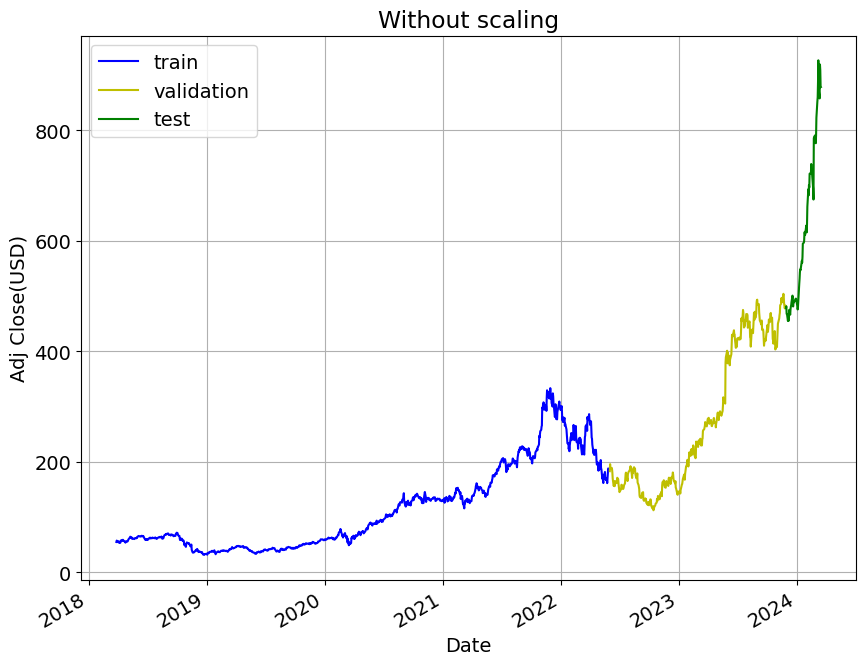

In [88]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='Date', y='Adj Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Adj Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj Close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close(USD)")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

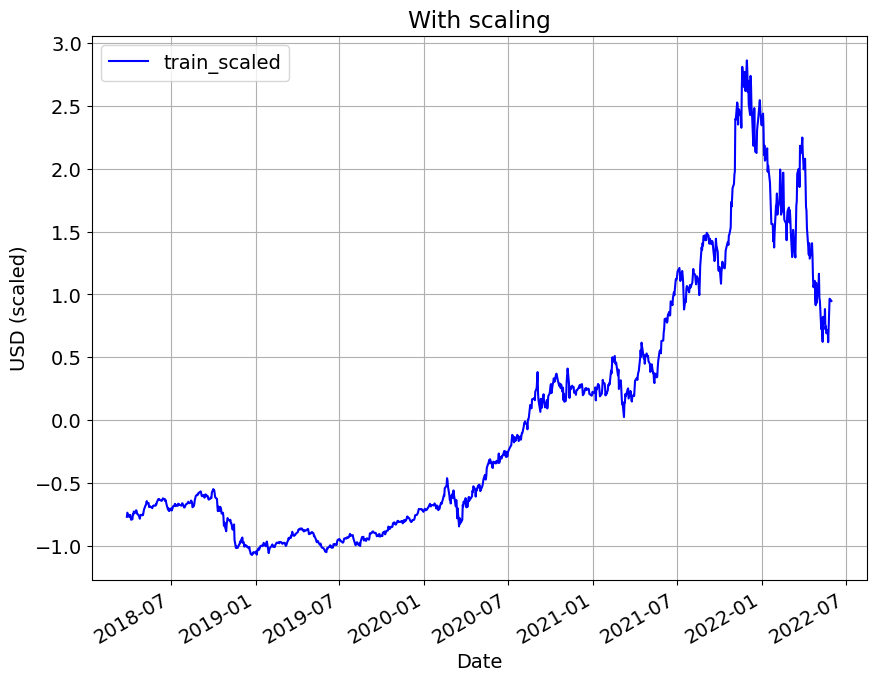

In [89]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='Date', y='Adj Close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("Date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

# Train the model using XGBoost

In [90]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the model using the training set
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=1,
             colsample_bynode=None, colsample_bytree=1, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [91]:
# Do prediction on training set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 2.571
MAPE on train set = 1.803%


Text(0, 0.5, 'Adj Close(USD)')

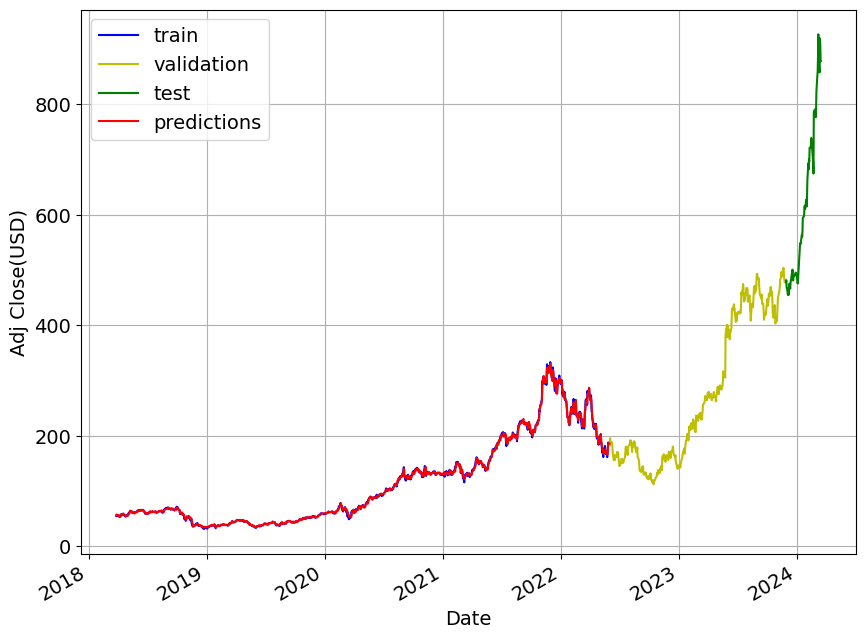

In [92]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'Date': train['Date']})

ax = train.plot(x='Date', y='Adj Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Adj Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj Close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close(USD)")
# ax.set_title('Without scaling')

Predict on the dev set

In [93]:
# Do prediction on dev set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['Adj Close_std'] + cv['Adj Close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 9.762
MAPE on dev set = 2.808%


C:\Users\Fiona\AppData\Local\Temp\ipykernel_12696\3837169052.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['est_scaled'] = est_scaled
C:\Users\Fiona\AppData\Local\Temp\ipykernel_12696\3837169052.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['est'] = cv['est_scaled'] * cv['Adj Close_std'] + cv['Adj Close_mean']


Text(0, 0.5, 'Adj Close(USD)')

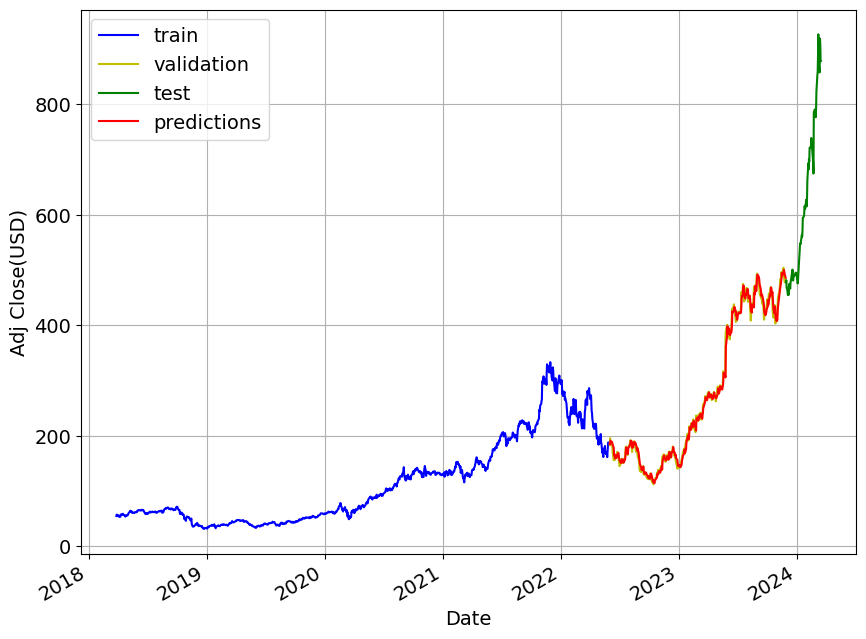

In [94]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'Date': cv['Date']})

ax = train.plot(x='Date', y='Adj Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Adj Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj Close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close(USD)")

Text(0.5, 1.0, 'Zoom in to validation set')

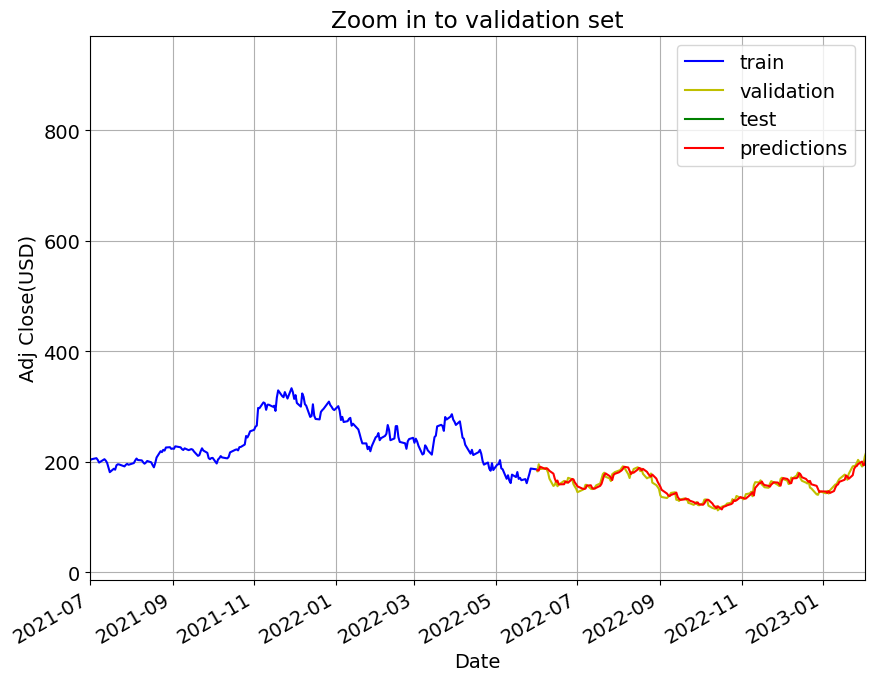

In [95]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='Date', y='Adj Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Adj Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj Close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close(USD)")
ax.set_xlim([date(2021, 7, 1), date(2023, 2, 1)])
ax.set_title("Zoom in to validation set")

The predictions capture the turn in directions with a slight lag

In [96]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('range_oc_lag_4', 0.0005317239),
 ('Volume_lag_7', 0.0005491393),
 ('range_hl_lag_2', 0.0005864965),
 ('Adj Close_lag_5', 0.0021719502),
 ('Adj Close_lag_3', 0.03934274),
 ('Adj Close_lag_7', 0.04357832),
 ('Adj Close_lag_6', 0.075515546),
 ('Adj Close_lag_4', 0.08212506),
 ('Adj Close_lag_1', 0.30683064),
 ('Adj Close_lag_2', 0.44269544)]

From the above result, we see that importance features are dominated by Adj Close and Volume

Use N = 7

# Tuning XGBoost - n_estimators (default=100) and max_depth (default=3)

In [97]:
param_label = 'n_estimators'
param_list = range(10, 100, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in param_list:
    print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['Adj Close_mean'],
                                     cv['Adj Close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

param = 10
param = 20
param = 30
param = 40
param = 50
param = 60
param = 70
param = 80
param = 90


Minutes taken = 0.23821271657943727


,n_estimators,max_depth,rmse,mape_pct
0,10,2,10.879303,3.120439
1,10,3,10.862270,3.109869
2,10,4,10.822952,3.104017
3,10,5,11.077626,3.190534
4,10,6,10.960182,3.148345
...,...,...,...,...
67,90,5,10.240735,2.951746
68,90,6,10.220602,2.950208
69,90,7,10.179863,2.936334
70,90,8,10.226241,2.941415


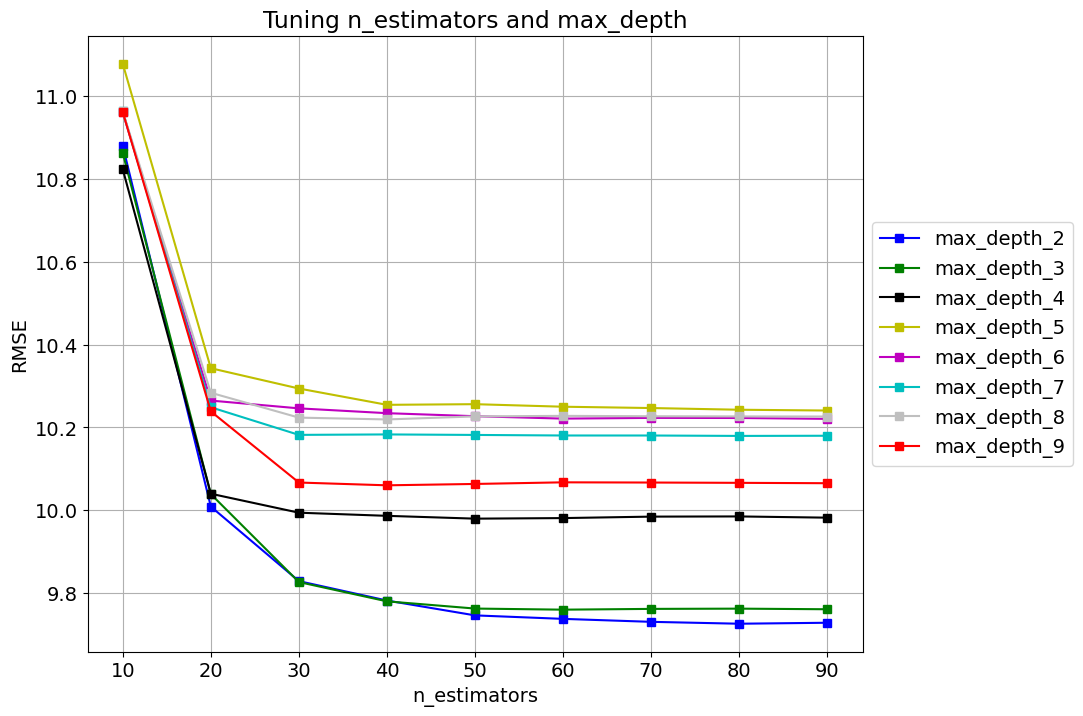

In [98]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
ax.set_title("Tuning n_estimators and max_depth")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [99]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 9.726
optimum params = 


(80, 2)

In [100]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 2.772%
optimum params = 


(80, 2)

n_estimator = 80, max_depth = 2

# Tuning XGBoost - learning_rate(default=0.1) and min_child_weight(default=1)

In [101]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in param_list:
    print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['Adj Close_mean'],
                                     cv['Adj Close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

param = 0.001
param = 0.005


param = 0.01


KeyboardInterrupt: 

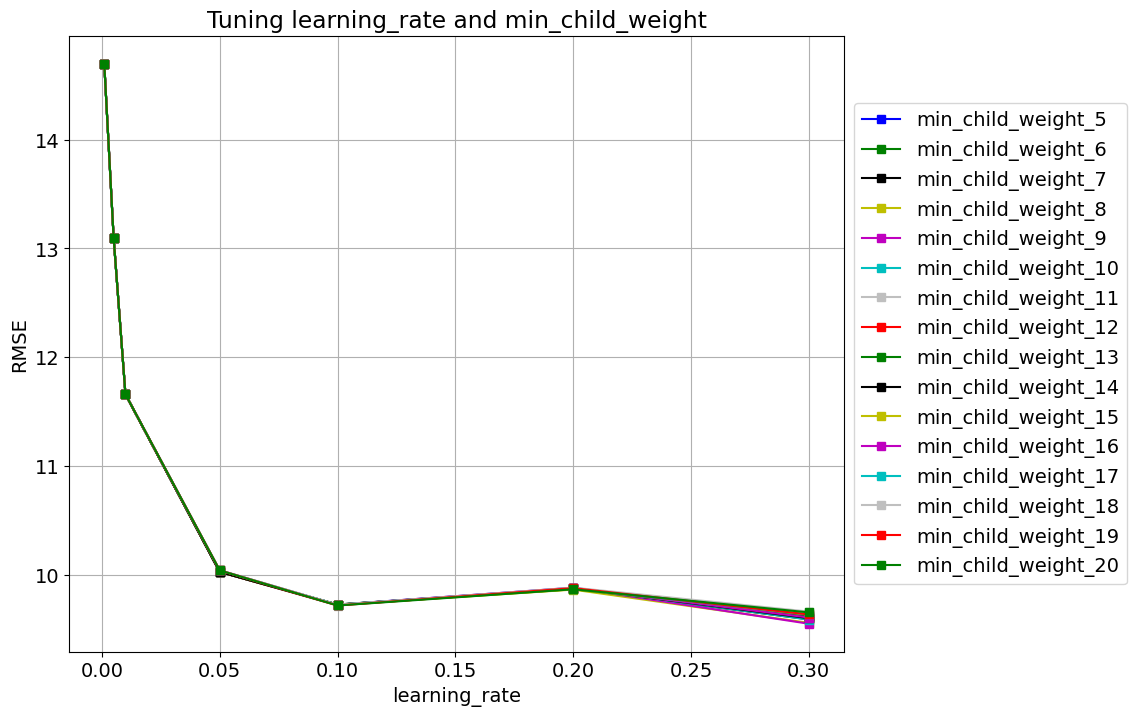

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
ax.set_title("Tuning learning_rate and min_child_weight")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 9.555
optimum params = 


(0.3, 9)

In [ ]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 2.730%
optimum params = 


(0.3, 9)

learning rate = 0.3, max_children = 9

# Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [ ]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in param_list:
    print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['Adj Close_mean'],
                                     cv['Adj Close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

param = 0.1
param = 0.2


param = 0.3
param = 0.4
param = 0.5
param = 0.6
param = 0.7
param = 0.8
param = 0.9
param = 1
Minutes taken = 0.062225929896036786


,subsample,gamma,rmse,mape_pct
0,0.1,0.1,9.381887,2.702957
1,0.1,0.2,9.338543,2.700359
2,0.1,0.3,9.424330,2.730594
3,0.1,0.4,9.339484,2.695071
4,0.1,0.5,9.387234,2.713530
...,...,...,...,...
95,1.0,0.6,9.678910,2.773694
96,1.0,0.7,9.683851,2.774848
97,1.0,0.8,9.693410,2.775598
98,1.0,0.9,9.717027,2.784863


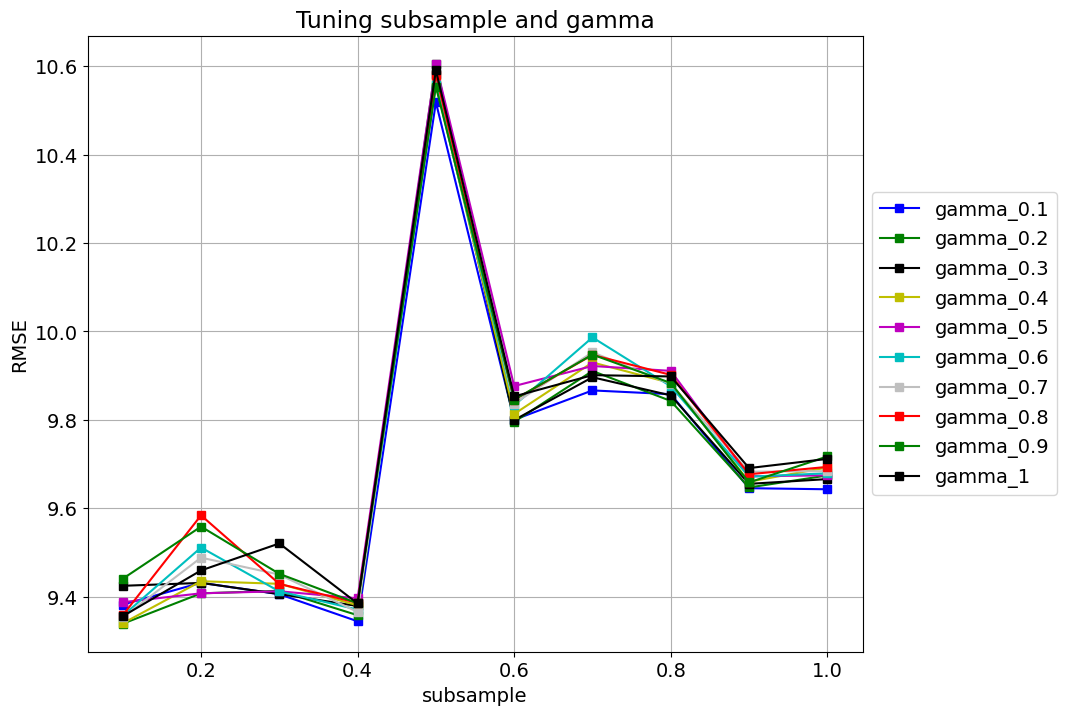

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
ax.set_title("Tuning subsample and gamma")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 9.339
optimum params = 


(0.1, 0.2)

In [ ]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 2.682%
optimum params = 


(0.3, 0.1)

# Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)

In [ ]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in param_list:
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['Adj Close_mean'],
                                     cv['Adj Close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

Minutes taken = 0.02346404790878296


,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,13.024177,3.763638
1,0.5,0.6,13.038958,3.768664
2,0.5,0.7,13.170339,3.774609
3,0.5,0.8,12.608241,3.660544
4,0.5,0.9,12.608241,3.660544
5,0.5,1.0,12.049424,3.428799
6,0.6,0.5,13.634239,3.945908
7,0.6,0.6,13.397288,3.868370
8,0.6,0.7,12.917363,3.764308
9,0.6,0.8,12.917363,3.764308


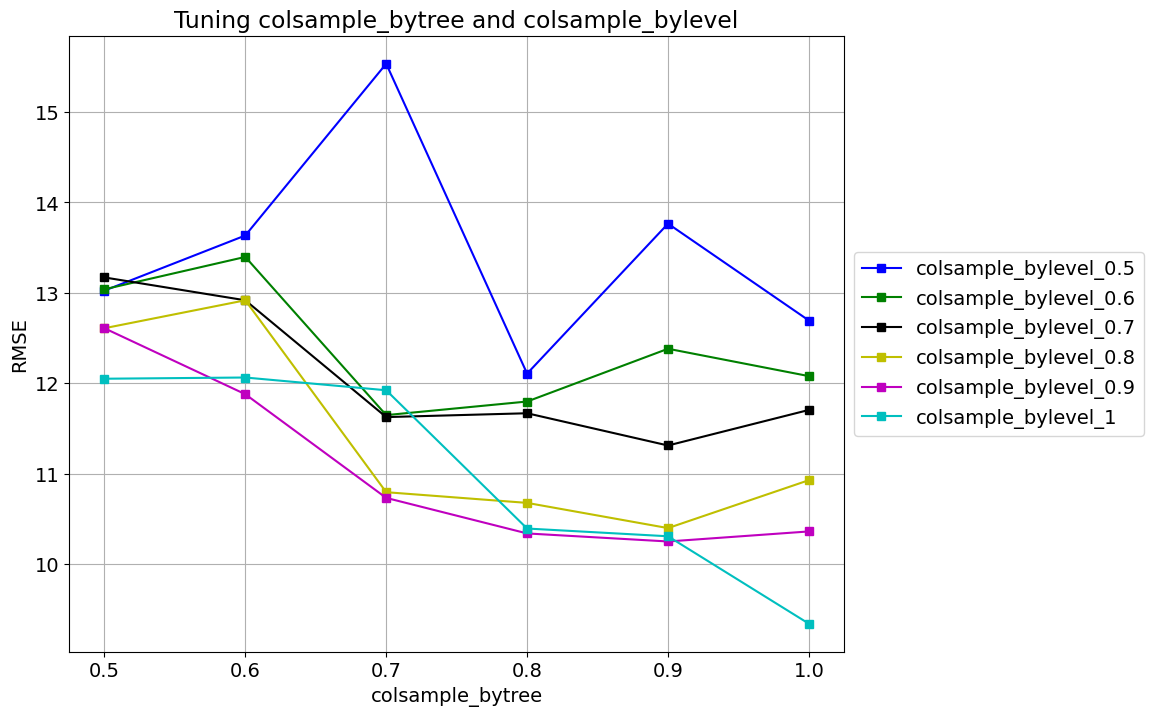

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
ax.set_title("Tuning colsample_bytree and colsample_bylevel")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 9.339
optimum params = 


(1.0, 1.0)

In [ ]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 2.700%
optimum params = 


(1.0, 1.0)

# Tuned params

In [ ]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,80.000
1,max_depth,3.000,2.000
2,learning_rate,0.100,0.300
3,min_child_weight,1.000,9.000
4,subsample,1.000,0.100
5,colsample_bytree,1.000,1.000
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.200
8,rmse,9.762,9.339
9,mape_pct,2.808,2.700


# Final model

In [ ]:
# Rmse, Mape, Est = train_pred_eval_model(X_train_cv_scaled, 
#                              y_train_cv_scaled, 
#                              X_train_cv, 
#                              y_train_cv, 
#                              train_cv['Adj Close_mean'],
#                              train_cv['Adj Close_std'],
#                              seed=model_seed,
#                              n_estimators=n_estimators_opt, 
#                              max_depth=max_depth_opt, 
#                              learning_rate=learning_rate_opt, 
#                              min_child_weight=min_child_weight_opt, 
#                              subsample=subsample_opt, 
#                              colsample_bytree=colsample_bytree_opt, 
#                              colsample_bylevel=colsample_bylevel_opt, 
#                              gamma=gamma_opt)

# # Calculate RMSE
# print("RMSE on training + validation set = %0.3f" % Rmse)

# # Calculate MAPE
# print("MAPE on training + validation set = %0.3f%%" % Mape)

ValueError: Input contains NaN.

In [ ]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['Adj Close_mean'],
                             test['Adj Close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 21.366
MAPE on test set = 2.355%


Text(0.5, 1.0, 'XGBoost forecasting plot')

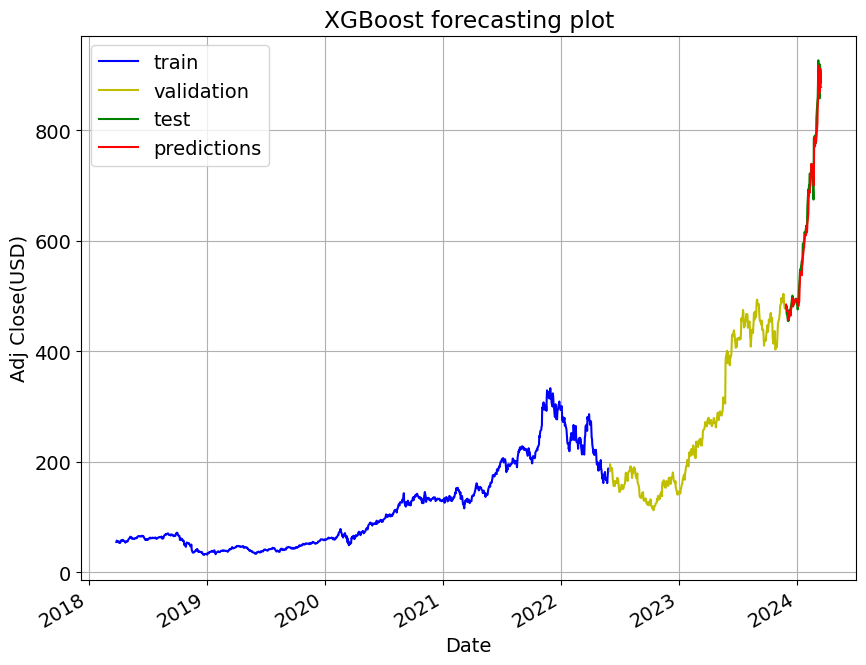

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'Date': test['Date']})

ax = train.plot(x='Date', y='Adj Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Adj Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj Close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close(USD)")
ax.set_title("XGBoost forecasting plot")

Text(0.5, 1.0, 'Zoom in to test set')

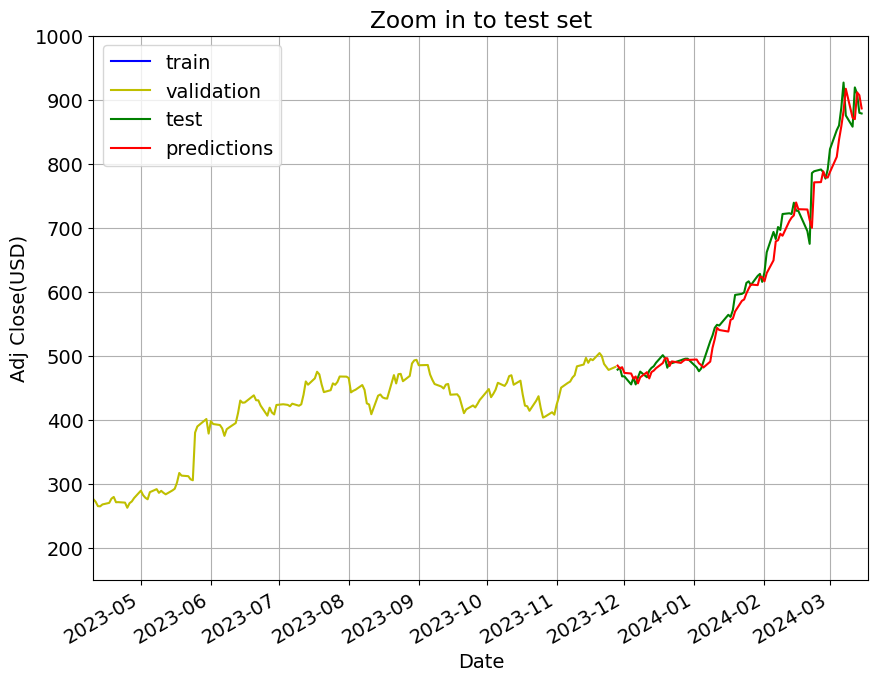

In [ ]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='Date', y='Adj Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Adj Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj Close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close(USD)")
ax.set_xlim([date(2023, 4, 10), date(2024, 3, 18)])
ax.set_ylim([150, 1000])
ax.set_title("Zoom in to test set")

Text(0.5, 1.0, 'XGBoost-Zoom in to test set')

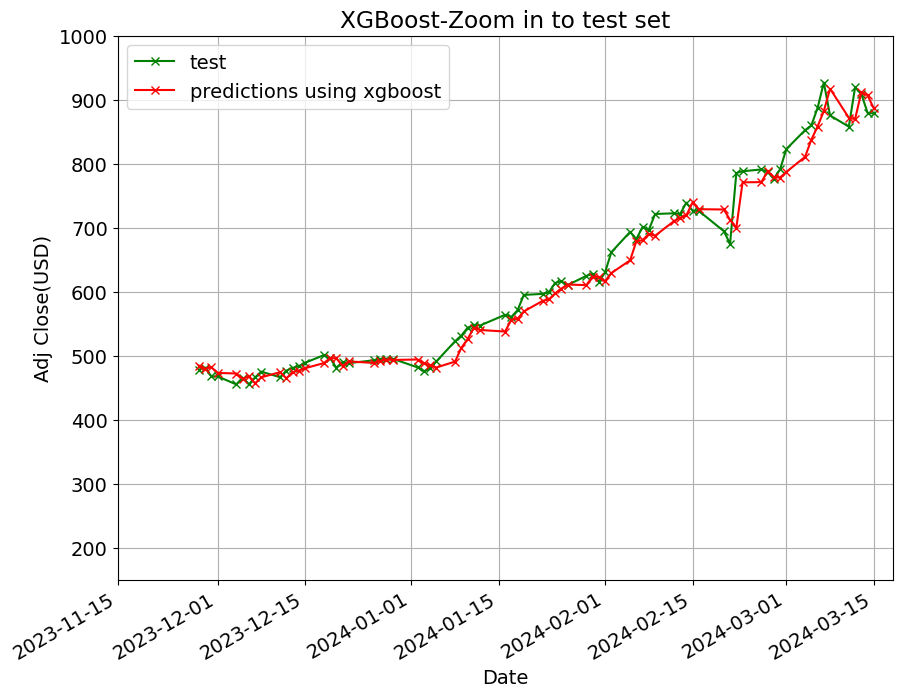

In [ ]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='Date', y='Adj Close', style='gx-', grid=True)
ax = est_df.plot(x='Date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close(USD)")
ax.set_xlim([date(2023, 11, 15), date(2024, 3, 18)])
ax.set_ylim([150, 1000])
ax.set_title("XGBoost-Zoom in to test set")

ARIMA

In [ ]:
d = pd.read_csv('C:/Users/Fiona/Desktop/英伟达.csv')
data = pd.DataFrame(d[['Date', 'Adj Close']])
type(data)
data

,Date,Adj Close
0,2018-03-19,59.649902
1,2018-03-20,61.773552
2,2018-03-21,61.521091
3,2018-03-22,59.860310
4,2018-03-23,57.662403
...,...,...
1504,2024-03-11,857.739990
1505,2024-03-12,919.130005
1506,2024-03-13,908.880005
1507,2024-03-14,879.440002


In [ ]:
num_valid = int(test_size*len(data))
num_train = len(data) - num_valid
print("total number = ", len(data))
print("num_train = " + str(num_train))
print("num_valid = " + str(num_valid))

# Split into train, cv, and test
traind = data[:num_train][['Date', 'Adj Close']]
valid = data[num_train:][['Date', 'Adj Close']]
print("train shape = " + str(traind.shape))
print("validation shape = " + str(valid.shape))

total number =  1509
num_train = 1434
num_valid = 75
train shape = (1434, 2)
validation shape = (75, 2)


ACF and PACF plots

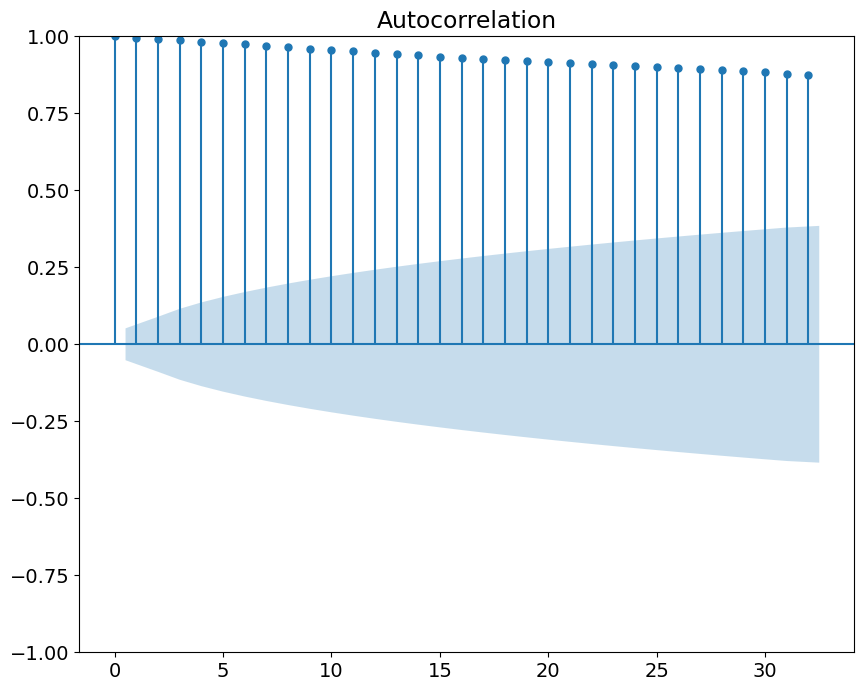

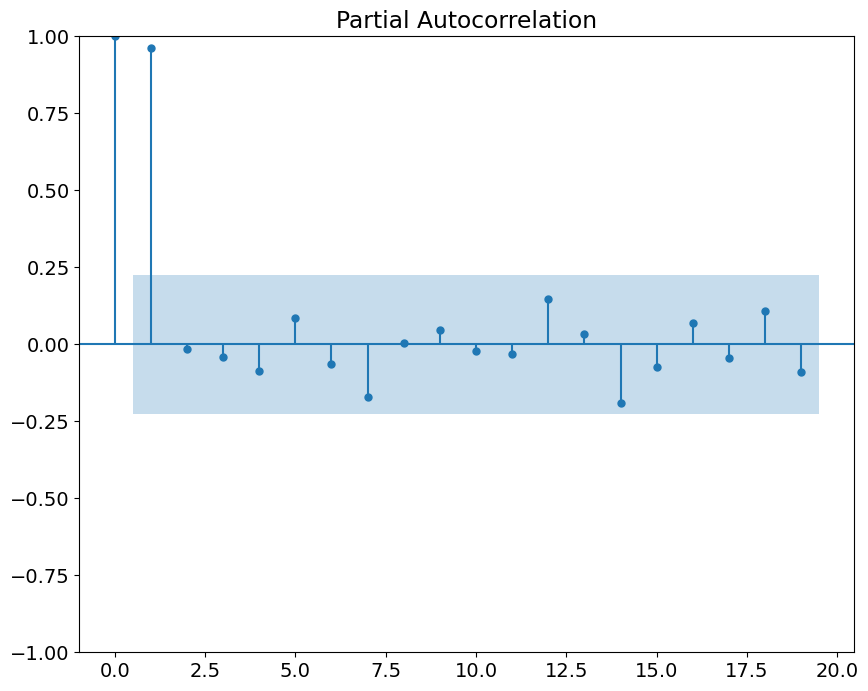

In [102]:
# ACF and PACF plots:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_orig = plot_acf(traind['Adj Close'])
pacf_orig = plot_pacf(valid['Adj Close'])

ADF Test

In [103]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(traind['Adj Close'])
print(f'p-value: {adf_test[1]}')


p-value: 0.9952412543987788


p-value > 0.05, so we need to do the differencing

In [105]:
traind['Adj_Close'] = train['Adj Close'].diff().dropna()
traind

,Date,Adj Close,Adj_Close
0,2018-03-19,NaN,NaN
1,2018-03-20,NaN,NaN
2,2018-03-21,NaN,NaN
3,2018-03-22,NaN,NaN
4,2018-03-23,NaN,NaN
...,...,...,...
1429,2023-11-20,NaN,NaN
1430,2023-11-21,NaN,NaN
1431,2023-11-22,NaN,NaN
1432,2023-11-24,NaN,NaN


In [ ]:
traind['Adj_Close'].plot()

In [ ]:
acf_diff = plot_acf(traind['Adj_Close'])
pacf_diff = plot_pacf(traind['Adj_Close'])

In [ ]:
# ADF test again
adf_test2 = adfuller(traind['Adj_Close'])
print(f'p-value: {adf_test2[1]}')
print(format(adf_test2[1], '.4f'))


p-value < 0.05, so we can accept it.
So, d = 1

In [ ]:
scaler = StandardScaler()
traind_scaled = scaler.fit_transform(pd.DataFrame(traind['Adj Close']))
traind_scaled
train_new = pd.concat([traind, pd.Series(traind_scaled[:,0])], axis=1)
train_new = train_new.rename(columns={0: "adj close"})
train_new

,Date,Adj Close,adj close
0,2018-03-19,59.649902,-0.820854
1,2018-03-20,61.773552,-0.802714
2,2018-03-21,61.521091,-0.804870
3,2018-03-22,59.860310,-0.819056
4,2018-03-23,57.662403,-0.837831
...,...,...,...
1429,2023-11-20,504.022034,2.974914
1430,2023-11-21,499.372650,2.935199
1431,2023-11-22,487.094330,2.830320
1432,2023-11-24,477.695618,2.750037


In [ ]:
scaler2 = StandardScaler()
valid_scaled = scaler2.fit_transform(pd.DataFrame(valid['Adj Close']))
valid = valid.reset_index(drop=True)
valid_new = pd.concat([valid, pd.Series(valid_scaled[:,0])], axis=1)
valid_new = valid_new.rename(columns={0: "adj close"})
valid_new

,Date,Adj Close,adj close
0,2023-11-28,478.145508,-1.024678
1,2023-11-29,481.335083,-1.002734
2,2023-11-30,467.636963,-1.096976
3,2023-12-01,467.586945,-1.097320
4,2023-12-04,455.038666,-1.183651
...,...,...,...
70,2024-03-11,857.739990,1.586902
71,2024-03-12,919.130005,2.009260
72,2024-03-13,908.880005,1.938741
73,2024-03-14,879.440002,1.736196


In [57]:
import pmdarima as pm
from pmdarima import auto_arima

fit = auto_arima(train_new['adj close'], trace = True, suppress_warnings = True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4416.872, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4424.385, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4422.402, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4422.402, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4422.973, Time=0.06 sec


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4420.402, Time=0.49 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.168 seconds


In [58]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_new['adj close'], order = (0,1,0)).fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:              adj close   No. Observations:                 1434
Model:                 ARIMA(0, 1, 0)   Log Likelihood                2212.487
Date:                Sun, 24 Mar 2024   AIC                          -4422.973
Time:                        13:24:20   BIC                          -4417.705
Sample:                             0   HQIC                         -4421.006
                               - 1434                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0027   3.04e-05     87.751      0.000       0.003       0.003
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             22790.14
Prob(Q):                              0.90   Pr

In [59]:
train_pred = pd.concat([train_new, pd.Series(model.fittedvalues)], axis=1)
train_pred = train_pred.rename(columns={0: "prediction"})
train_pred

,Date,Adj Close,adj close,prediction
0,2018-03-19,59.649902,-0.820854,0.000000
1,2018-03-20,61.773552,-0.802714,-0.820854
2,2018-03-21,61.521091,-0.804870,-0.802714
3,2018-03-22,59.860310,-0.819056,-0.804870
4,2018-03-23,57.662403,-0.837831,-0.819056
...,...,...,...,...
1429,2023-11-20,504.022034,2.974914,2.880027
1430,2023-11-21,499.372650,2.935199,2.974914
1431,2023-11-22,487.094330,2.830320,2.935199
1432,2023-11-24,477.695618,2.750037,2.830320


In [70]:
# convert the prediction to original scale
# remove differencing
pred_nodiff = pd.DataFrame(train_pred['prediction'])
pred_nodiff = np.cumsum(pred_nodiff, axis=0)
pred_nodiff

# remove scaling
std = np.std(train_pred['Adj Close'])
mean = train_pred['Adj Close'].mean()
pred_noscl = pred_nodiff * std + mean
pred_noscl

,prediction
0,0.000000
1,-0.820854
2,-1.623567
3,-2.428437
4,-3.247494
...,...
1429,-14.280307
1430,-11.305393
1431,-8.370193
1432,-5.539874


c:\Users\Fiona\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


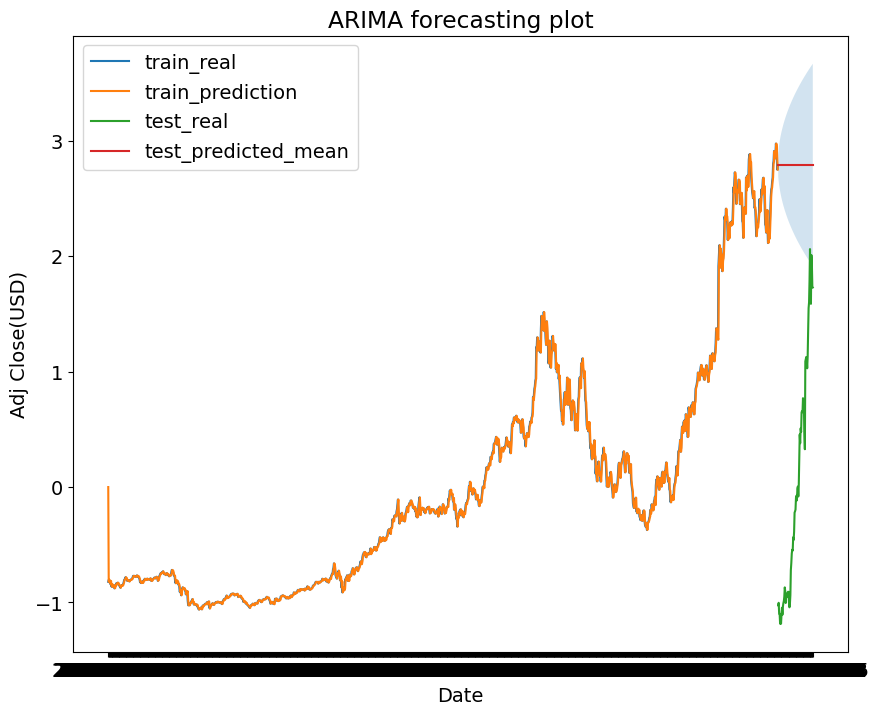

In [60]:
fore = model.get_forecast(75, alpha=0.05)
fc = fore.predicted_mean
fc = fc.reset_index(drop=True)
conf = fore.conf_int(alpha = 0.05)

# fc_series = pd.Series(fc, index=valid_new.index)
# valid_new = valid_new.reset_index(drop=True)
# valid_pred = pd.concat([valid_new, pd.Series(fc[:,0])], axis=1)
# valid_new = valid_new.rename(columns={0: "adj close"})
# valid_new

valid_pred = pd.concat([valid_new, pd.Series(fc)], axis=1)
valid_pred

plt.figure(figsize=(10,8), dpi=100)
plt.plot(train_new['Date'], train_new['adj close'], label='train_real')
plt.plot(train_pred['Date'], train_pred['prediction'], label='train_prediction')
plt.plot(valid_new['Date'], valid_new['adj close'], label='test_real')
plt.plot(valid_pred['Date'], valid_pred['predicted_mean'], label='test_predicted_mean')
plt.fill_between(valid_pred['Date'], conf.iloc[:,0],conf.iloc[:,1],alpha = 0.2)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

plt.title('ARIMA forecasting plot')
plt.xlabel('Date')
plt.ylabel('Adj Close(USD)')
plt.legend()
plt.show()

Text(0.5, 1.0, 'ARIMA forecasting plot')

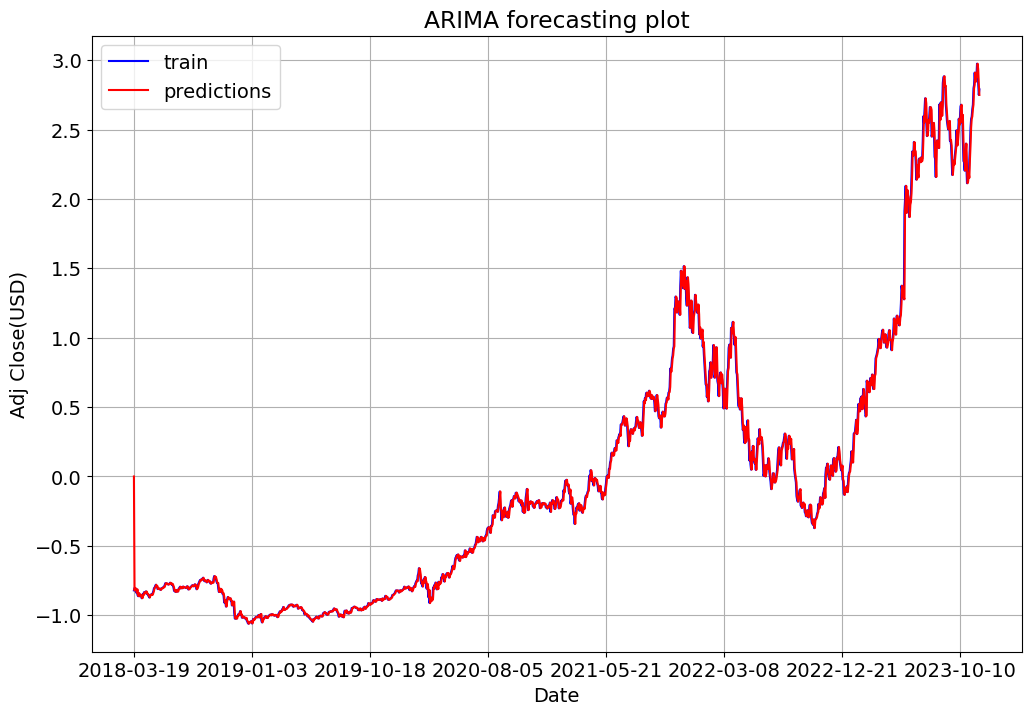

In [61]:
rcParams['figure.figsize'] = 12, 8 # width 10, height 8

ax = train_new.plot(x='Date', y='adj close', style='b-', grid=True)
# ax = cv.plot(x='Date', y='Adj Close', style='y-', grid=True, ax=ax)

ax = train_pred.plot(x='Date', y='prediction', style='r-', grid=True, ax=ax)
ax.legend(['train', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close(USD)")
ax.set_title("ARIMA forecasting plot")

In [62]:
from sklearn.metrics import mean_squared_error

aa_rmse = np.sqrt(mean_squared_error(train_pred['adj close'],train_pred['prediction']))
print('RMSE on training set = %0.3f'% aa_rmse)
aa_mape = get_mape(train_pred['adj close'],train_pred['prediction'])
print('MAPE on training set = %0.3f%%'% aa_mape)

RMSE on training set = 0.056
MAPE on training set = 29.636%


In [63]:
a_rmse = np.sqrt(mean_squared_error(valid_pred['adj close'],valid_pred['predicted_mean']))
print('RMSE on test set = %0.3f'% a_rmse)
a_mape = get_mape(valid_pred['adj close'],valid_pred['predicted_mean'])
print('MAPE on test set = %0.3f%%'% a_mape)

RMSE on test set = 2.964
MAPE on test set = 1790.553%
